In [14]:
import house_price_preprocessor
import warnings
warnings.filterwarnings(action='ignore')

In [34]:
train_dataset_dir = "./house_price/train.csv"
test_dataset_dir = "./house_price/test.csv"

In [35]:
train_X, test_X, train_y, test_id_idx = house_price_preprocessor.get_train_test_split_dataset(train_dataset_dir, test_dataset_dir)

In [36]:
# 데이터 분리
train_X.shape, test_X.shape, train_y.shape, test_id_idx.shape

((1460, 67), (1459, 67), (1460,), (1459,))

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression # 비교용 선형회귀

#from sklearn.cross_validation import cross_val_score 
from sklearn.model_selection import cross_val_score 



import numpy as np

In [38]:
gbr = GradientBoostingRegressor(n_estimators=2000, subsample=0.5, max_depth=2, learning_rate=0.55)
lr = LinearRegression()

In [39]:
# negative 이므로 클 수록 좋음, 회귀보다 큰 성능 차이를 보임
np.mean(cross_val_score(gbr, train_X, train_y, scoring="neg_mean_squared_error" , cv=5))

-1278209231.3706405

In [40]:
np.mean(cross_val_score(lr, train_X, train_y, scoring="neg_mean_squared_error" , cv=5))

-3.145851450924005e+32

In [41]:
# 평균 제곱근 오차(Root Mean Square Error)
# 사이킷런에서는 클수록 좋다고 판단(MSE에 음수를 취한 Negative Mean Square Error : 오차가 올라가면 나쁘다->점수가 올라가면 좋다)
# 그러나 rmse는 작을수록 좋은 것이라고 판단
# 그러므로 rmse를 지원하지 않아 따로 정의

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
# 튜닝
gbr = GradientBoostingRegressor(
        max_depth=2, n_estimators=5000, subsample=0.5,learning_rate=0.05)
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.3)

gbr.fit(X_train, y_train)

# staged_predict : 총 5000개 중에서 하나 생성 시 마다 predict
# x_train과 x_val이 벌어지는 순간 멈춰야하므로 staged_predict를 사용해 early stopping 및 적절한 estimator를 찾을 수 있음
errors_val = [rmse(y_val, y_pred) for y_pred in gbr.staged_predict(X_val)]
errors_train = [rmse(y_train, y_pred) for y_pred in gbr.staged_predict(X_train)]
x_axis = list(range(len(errors_val)))

lr = LinearRegression() # 비교대상
lr.fit(X_train, y_train)

LinearRegression()

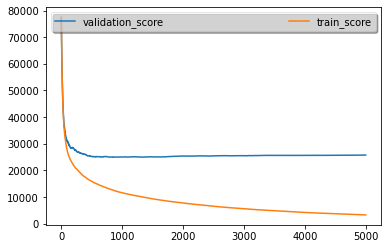

802 24924.909762810843
30951.585524520953


In [44]:
import matplotlib.pyplot as plt
import numpy as np


ax = plt.subplot(111)
plt.plot(x_axis, errors_val, label="validation_score")
plt.plot(x_axis, errors_train, label="train_score")

leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)


plt.show()
bst_n_estimators = np.argmin(errors_val) # errors_val의 최솟값
print(bst_n_estimators, errors_val[bst_n_estimators]) # 해당 인덱스와 값 출력
print(rmse(y_val, lr.predict(X_val))) # 선형회귀의 값

In [45]:
gbr_best = GradientBoostingRegressor(max_depth=2, subsample=0.5,learning_rate=0.05, n_estimators=bst_n_estimators)
gbr_best.fit(train_X, train_y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=802,
                          subsample=0.5)

In [46]:
id_value=test_id_idx #제출용 csv에 id를 명시해야하므로 
sales_price = gbr_best.predict(test_X) 

In [47]:
result = np.vstack([id_value, sales_price]).T

result

array([[  1461.        , 126398.28028954],
       [  1462.        , 154185.08297814],
       [  1463.        , 195583.53470102],
       ...,
       [  2917.        , 180301.98672867],
       [  2918.        , 128840.00670171],
       [  2919.        , 235799.72422842]])

In [48]:
# dataframe 변환
from pandas import DataFrame

DataFrame(result, dtype=int, columns=["Id", "SalePrice"]).set_index("Id").to_csv("house_price_result.csv")
# DataFrame(result, columns=["Id", "SalePrice"]).set_index("Id").to_csv("house_price_result.csv") -> 오류

In [50]:
# 가공 후 csv 출력
submission_df =DataFrame(result, columns=["Id", "SalePrice"]).set_index("Id")
submission_df.index = submission_df.index.astype(int)
submission_df.to_csv("house_price_result.csv")

In [52]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f house_price_result.csv -m "My submission"

zsh:1: command not found: kaggle


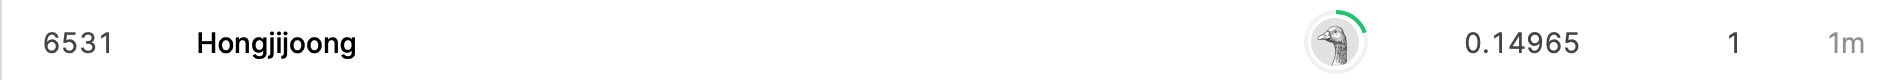

In [55]:
from IPython.display import Image
Image("/Users/jijoonghong/Downloads/ch13/first_commit.png")

In [60]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV 

param_grid={'n_estimators':[1000,1200,1300,1350,1360,1370,1380,1390,1400], 
                'learning_rate': [0.1, 0.05], #0.02, 0.01], 
                'subsample' : [0.4,0.5,0.55],#,0.6,0.7,0.8],
                'max_depth':[2, 4, 6],#,8], 
                'min_samples_leaf':[3, 5],#,9,15], 
                'max_features':[1.0, 0.3]#, 0.1] 
           } 
n_jobs=7 

estimator = GradientBoostingRegressor(warm_start=True)
cv = ShuffleSplit(n_splits=5, train_size = X_train.shape[0], test_size=0.2) #변경
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs, verbose=1)

classifier.fit(train_X, train_y)
print (classifier.best_estimator_)  

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features=0.3,
                          min_samples_leaf=3, n_estimators=1380, subsample=0.5,
                          warm_start=True)


In [61]:
print(rmse(y_val, classifier.best_estimator_.predict(X_val)))
#상당한 개선이 이뤄짐

3702.6504514318467


In [62]:
final_estimator = classifier.best_estimator_
final_estimator.fit(train_X, train_y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features=0.3,
                          min_samples_leaf=3, n_estimators=1380, subsample=0.5,
                          warm_start=True)

In [65]:
id_value=test_id_idx
sales_price = final_estimator.predict(test_X)
result = np.vstack([id_value, sales_price]).T
submission_df =DataFrame(result, columns=["Id", "SalePrice"]).set_index("Id")
submission_df.index = submission_df.index.astype(int)
submission_df.to_csv("house_price_result_grid_search.csv")


In [66]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f house_price_result_grid_search.csv -m "Message"

zsh:1: command not found: kaggle
